In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline


## running the model

In [3]:
from Regard import init
args = init(verbose=1, epochs = 30)
print('Parameters=', args)

path = '_Regard.pt'

Parameters= {'batch_size': 16, 'test_batch_size': 1, 'valid_size': 0.2, 'epochs': 30, 'do_adam': False, 'lr': 0.0065, 'momentum': 0.48, 'no_cuda': True, 'num_processes': 1, 'seed': 42, 'log_interval': 10, 'fullsize': 350, 'crop': 320, 'size': 280, 'mean': 0.36, 'std': 0.3, 'conv1_dim': 8, 'conv1_kernel_size': 9, 'conv2_dim': 8, 'conv2_kernel_size': 9, 'stride1': 4, 'stride2': 4, 'dimension': 25, 'verbose': 1}


In [4]:
from Regard import ML
ml = ML(args)

import os
import torch
ml.model.load_state_dict(torch.load(path))
print('Loading file', path)



cuda? False
cuda? False
Found 796 sample images;  637  to train 159 to test
Loading file _Regard.pt


In [5]:
ml.dataset.dataset.classes

['blink', 'center', 'left', 'right']

    content_image = utils.load_image(args.content_image, scale=args.content_scale)

## testing the model

In [6]:
import imageio
image = imageio.imread('./dataset/right/2018-03-20_Nicolas_40.png')
image = (image-image.min())/(image.max()-image.min()) * 1.
image *= args.std
image += args.mean
print('size of input image', image.shape)

size of input image (243, 243, 3)


In [7]:
from PIL import Image
image = Image.open('./dataset/right/2018-03-20_Nicolas_40.png')
print('size of input image', image.height, image.width)

size of input image 243 243


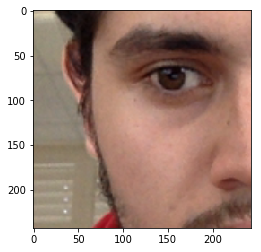

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

#show the image
plt.imshow(image)
plt.show() 

In [9]:
from torchvision import transforms

#t = transforms.Normalize(mean=args.mean, std=args.std)
t = transforms.Compose([
    transforms.CenterCrop(args.crop),
    transforms.Resize(args.size),
    transforms.ToTensor(),
    #transforms.Normalize(mean=self.IMAGENET_MEAN, std=self.IMAGENET_STD),
    transforms.Normalize(mean=[args.mean]*3, std=[args.std]*3),
    ])


data = t(image)
data.unsqueeze_(0)

print('size of data image', data.shape)


size of data image torch.Size([1, 3, 280, 280])


In [10]:
output = ml.model(data)#.double())

In [11]:
output


tensor([[-20.3686,   0.0000, -16.2748, -21.5550]], grad_fn=<LogSoftmaxBackward>)

In [12]:
def classify(image, t):
    data = t(image)
    data.unsqueeze_(0)
    output = ml.model(data)#.double())
    #output = ml.model.forward(image)

    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    return pred

import time
t0 = time.time()
pred = classify(image, t)
print('Elapsed time =', (time.time()-t0)*1000, 'ms')
print('Prediction =', ml.dataset.dataset.classes[pred])

Elapsed time = 65.55485725402832 ms
Prediction = center


In [13]:
import numpy as np
data = torch.from_numpy(np.transpose(image, (2, 0, 1)))
#data = torch.from_numpy(image)
print('size of data image', data.shape)


size of data image torch.Size([3, 243, 243])


In [14]:
data = torch.randn((3, 243, 243))
print('size of data image', data.shape)



size of data image torch.Size([3, 243, 243])


In [15]:
#t = transforms.Normalize(mean=args.mean, std=args.std)
t = transforms.Compose([
    transforms.CenterCrop(args.crop),
    transforms.Resize(args.size),
    transforms.ToTensor(),
    #transforms.Normalize(mean=self.IMAGENET_MEAN, std=self.IMAGENET_STD),
    transforms.Normalize(mean=[args.mean]*3, std=[args.std]*3),
    ])

#data = t(data)
#print('size of data image', data.shape)


# dynamical test

In [16]:
from LeCheapEyeTracker.EyeTrackerServer import Server
#from LeCheapEyeTracker.EyeTrackerClient import Client

def classify(image, t):
    image = Image.fromarray(image.astype('uint8'), 'RGB')
    data = t(image)
    data.unsqueeze_(0)
    output = ml.model(data)#.double())
    #output = ml.model.forward(image)
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    return pred



def dyn_test(N_frame=64, startup_time=1., interframe_time=0., waiting_time=.0, display=False):
    try:
        import time
        time.sleep(startup_time)
        et = Server()
        print ('Time', et.clock())
        img0 = et.cam.grab()
        img_face, res, t0 = et.process_frame(img0, et.clock())
        H, W, three = img_face.shape
        
        for i in range(N_frame):            
            # presentation of stimulus
            time.sleep(interframe_time)

            t0 = time.time()
            try:
                frame = et.cam.grab()
                img_face, res, t0_ = et.process_frame(frame, et.clock())
                img_face = img_face[:, :, ::-1]

                pred = classify(img_face, t)
                if display:
                    plt.imshow(img_face)
                    plt.show() 
                print('Prediction =', ml.dataset.dataset.classes[pred])
                print('Elapsed time =', '%0.3f' % ((time.time()-t0)*1000), 'ms')
            except:
                pass
            time.sleep(waiting_time)
            
    finally:
        et.close()
        
dyn_test(display=True)        

/Users/lolo/research/Shared/2018-03-19_StageL3/LeCheapEyeTracker/src/LeCheapEyeTracker/haarcascade_frontalface_default.xml
Time 349285.697755364
Capture released


IndexError: tuple index out of range